**Assignment 3: Time-Series Data**

By: Harika Beesetti and Arvind Chaurasia 

Use any or all of the methods we discussed in class to improve weather time-series forecasting problems discussed in class. These methods can include. 

1. Adjusting the number of units in each recurrent layer in the stacked setup
2. Using layer_lstm() instead of layer_gru().
3. Using a combination of 1d_convnets and RNN.

Run the best-performing models (in terms of validation MAE) on the test set!

In [1]:
#First we will download the data and unzip our file.
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-07 23:07:29--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.203.80, 52.217.113.80, 52.216.115.61, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.203.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

100%[======================================>] 13,565,642  10.2MB/s   in 1.3s   

2024-04-07 23:07:31 (10.2 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
#Let's exploare our dataset.

import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


Now, convert all 420,551 lines of data into NumPy arrays: one array for the temperature (in degrees Celsius), and another one for the rest of the data—the features wewill use to predict future temperatures. Note that we discard the “Date Time” column

In [3]:
#Parsing the data

import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

Now we will plot the temperature (in degrees Celsius) over time.

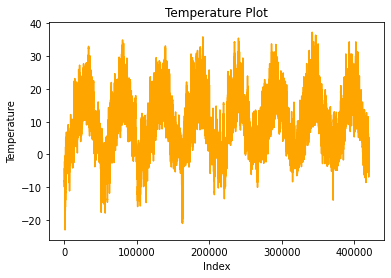

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature, color='orange')
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.title('Temperature Plot')
plt.show()

It is important to note that we get 24 × 6 = 144 data points per day. Now let us plot temperature for the first 15 days. 

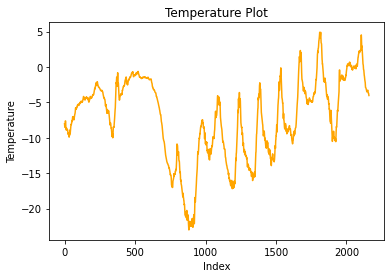

In [5]:
plt.plot(range(2160), temperature[:2160], color='orange')
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.title('Temperature Plot')
plt.show()

Now, we’ll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing.

In [6]:
#Let's computing the number of samples we’ll use for each data split.

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


Preparing our data

As we know that data is in numerical form. We will normalize each time series indepepdently, to make them all take small values on a similar scale. 

In [7]:
#Normalizing the data

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In ordere to instantiate lets use timeseries_dataset_from_array() for traing, validation and testing. 

In [8]:
from tensorflow import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
raw_data[:-delay],
targets=temperature[delay:],
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size,
start_index=0,
end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
raw_data[:-delay],
targets=temperature[delay:],
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size,
start_index=num_train_samples,
end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
raw_data[:-delay],
targets=temperature[delay:],
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size,
start_index=num_train_samples + num_val_samples)

Let's inspect the output of one of the datasets 

In [9]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

for samples, targets in val_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break
    
for samples, targets in test_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)
samples shape: (256, 120, 14)
targets shape: (256,)
samples shape: (256, 120, 14)
targets shape: (256,)


Before implementing the deep learning models let's try a simple common sense approch. This approach is really helpful when we are trying to build the models for the unkown situation. 

**Firstly, computing the common-sense baseline mean absoulte error (MAE)**

In [10]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"The Validation MAE is: {evaluate_naive_method(val_dataset):.2f}")
print(f"The Test MAE is: {evaluate_naive_method(test_dataset):.2f}")

The Validation MAE is: 2.44
The Test MAE is: 2.62


This MAE tell us that every 24 hours the temperature will be off set by 2.5 hr on an average. 

Now we will use a basic machine learning model. We will make small, densely connected network. 

**Training and evaluating a densely connected model.**

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
keras.callbacks.ModelCheckpoint("jena_dense.keras",
save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
epochs=10,
validation_data=val_dataset,
callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"The Test MAE is : {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 11s 13ms/step - loss: 12.7524 - mae: 2.7670 - val_loss: 10.0489 - val_mae: 2.4933
Epoch 2/10
819/819 [==============================] - 10s 12ms/step - loss: 9.1463 - mae: 2.3749 - val_loss: 9.9793 - val_mae: 2.4867
Epoch 3/10
819/819 [==============================] - 10s 12ms/step - loss: 8.3506 - mae: 2.2694 - val_loss: 12.6477 - val_mae: 2.8370
Epoch 4/10
819/819 [==============================] - 10s 12ms/step - loss: 7.8607 - mae: 2.2043 - val_loss: 10.2836 - val_mae: 2.5231
Epoch 5/10
819/819 [==============================] - 10s 12ms/step - loss: 7.4872 - mae: 2.1541 - val_loss: 10.4814 - val_mae: 2.5539
Epoch 6/10
819/819 [==============================] - 9s 11ms/step - loss: 7.1920 - mae: 2.1095 - val_loss: 10.8349 - val_mae: 2.5978
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 6.9725 - mae: 2.0773 - val_loss: 13.1441 - val_mae: 2.8864
Epoch 8/10
819/819 [==============================] - 9s 

Now we will plot our results. The loss curves for validation and training. 

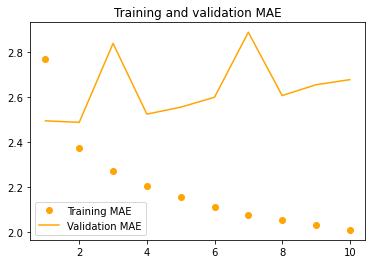

In [12]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "o", color='orange', label="Training MAE")  
plt.plot(epochs, val_loss, "-", color='orange', label="Validation MAE")  
plt.title("Training and validation MAE")
plt.legend()
plt.show()


The graph shows the Training and Validation MAE on the data temperature forecasting task with a simple, densely connected etwork.

As you can see that some of the validation losses are close to the no-learning baseline, but not reliably. 

**Building a 1D convolutional model**

In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
keras.callbacks.ModelCheckpoint("jena_conv.keras",
save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
epochs=10,
validation_data=val_dataset,
callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 26s 31ms/step - loss: 21.3820 - mae: 3.6314 - val_loss: 16.4431 - val_mae: 3.2259
Epoch 2/10
819/819 [==============================] - 25s 30ms/step - loss: 15.1992 - mae: 3.0921 - val_loss: 16.4824 - val_mae: 3.2389
Epoch 3/10
819/819 [==============================] - 25s 31ms/step - loss: 13.8035 - mae: 2.9469 - val_loss: 15.3055 - val_mae: 3.1023
Epoch 4/10
819/819 [==============================] - 25s 31ms/step - loss: 12.9160 - mae: 2.8479 - val_loss: 16.0742 - val_mae: 3.1751
Epoch 5/10
819/819 [==============================] - 24s 30ms/step - loss: 12.2781 - mae: 2.7727 - val_loss: 14.7637 - val_mae: 3.0384
Epoch 6/10
819/819 [==============================] - 25s 30ms/step - loss: 11.7985 - mae: 2.7163 - val_loss: 14.3611 - val_mae: 3.0020
Epoch 7/10
819/819 [==============================] - 23s 28ms/step - loss: 11.3913 - mae: 2.6677 - val_loss: 14.3943 - val_mae: 3.0027
Epoch 8/10
819/819 [============================

As we can see that this model performs even worse than the densely connected one,only achieving a validation MAE of about 3.2 degrees, far from the common-sense baseline. This is because the Max Pooling and global avergae pooling layers are hamperimg the order infromation. Also, weather data is only translational invariant for a very specific timescale. 

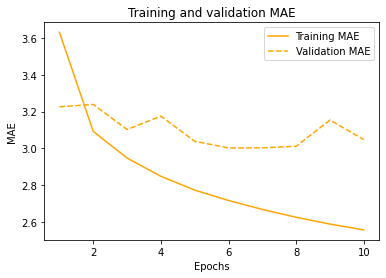

In [14]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="orange", linestyle="-", label="Training MAE")
plt.plot(epochs,  val_loss, color="orange", linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Let's make a simple LSTM model.**

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
keras.callbacks.ModelCheckpoint("jena_lstm.keras",
save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
epochs=10,
validation_data=val_dataset,
callbacks=callbacks)



Epoch 1/10
819/819 [==============================] - 43s 52ms/step - loss: 44.8086 - mae: 4.8722 - val_loss: 12.9988 - val_mae: 2.7478
Epoch 2/10
819/819 [==============================] - 43s 53ms/step - loss: 11.1273 - mae: 2.5966 - val_loss: 9.8628 - val_mae: 2.4404
Epoch 3/10
819/819 [==============================] - 44s 54ms/step - loss: 9.9515 - mae: 2.4631 - val_loss: 10.1735 - val_mae: 2.4592
Epoch 4/10
819/819 [==============================] - 44s 53ms/step - loss: 9.5112 - mae: 2.4023 - val_loss: 9.6620 - val_mae: 2.3968
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 9.2523 - mae: 2.3657 - val_loss: 10.0436 - val_mae: 2.4339
Epoch 6/10
819/819 [==============================] - 44s 53ms/step - loss: 9.0296 - mae: 2.3341 - val_loss: 10.3286 - val_mae: 2.4630
Epoch 7/10
819/819 [==============================] - 43s 53ms/step - loss: 8.7968 - mae: 2.3016 - val_loss: 9.8066 - val_mae: 2.4274
Epoch 8/10
819/819 [==============================] - 43

405/405 [==============================] - 7s 16ms/step - loss: 11.0611 - mae: 2.6004
Test MAE: 2.60


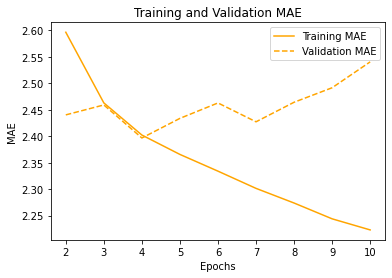

In [16]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

train_mae = history.history["mae"]
val_mae = history.history["val_mae"]

# Omitting the first epoch (index 0)
epochs = range(2, len(train_mae) + 1)

# Plotting Training and Validation MAE
plt.plot(epochs, train_mae[1:], color="orange", linestyle="-", label='Training MAE')  
plt.plot(epochs, val_mae[1:], color="orange", linestyle="dashed", label='Validation MAE')  
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

We achieve a validation MAE as low as 2.49 degrees and a test MAE of 2.58 degrees. The LSTM-based model can finally beat the
common-sense baseline. 

**A simple RNN Model**

**An RNN layer that can process sequences of any length**

In [17]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 20s 24ms/step - loss: 138.7953 - mae: 9.7084 - val_loss: 144.1682 - val_mae: 9.9185
Epoch 2/10
819/819 [==============================] - 20s 24ms/step - loss: 136.5190 - mae: 9.5718 - val_loss: 143.7801 - val_mae: 9.8803
Epoch 3/10
819/819 [==============================] - 18s 22ms/step - loss: 136.3273 - mae: 9.5548 - val_loss: 143.7204 - val_mae: 9.8750
Epoch 4/10
819/819 [==============================] - 19s 24ms/step - loss: 136.2243 - mae: 9.5448 - val_loss: 143.6130 - val_mae: 9.8610
Epoch 5/10
819/819 [==============================] - 19s 24ms/step - loss: 136.1515 - mae: 9.5369 - val_loss: 143.5657 - val_mae: 9.8557
Epoch 6/10
819/819 [==============================] - 19s 23ms/step - loss: 136.1363 - mae: 9.5356 - val_loss: 143.5649 - val_mae: 9.8547
Epoch 7/10
819/819 [==============================] - 19s 23ms/step - loss: 136.1193 - mae: 9.5332 - val_loss: 143.5608 - val_mae: 9.8538
Epoch 8/10
819/819 [==============

**Stacking RNN layers**

In [18]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 55s 66ms/step - loss: 136.9468 - mae: 9.5705 - val_loss: 143.6456 - val_mae: 9.8665
Epoch 2/10
819/819 [==============================] - 54s 66ms/step - loss: 135.9754 - mae: 9.5150 - val_loss: 143.4429 - val_mae: 9.8374
Epoch 3/10
819/819 [==============================] - 52s 64ms/step - loss: 135.9196 - mae: 9.5077 - val_loss: 143.4382 - val_mae: 9.8375
Epoch 4/10
819/819 [==============================] - 51s 63ms/step - loss: 135.8978 - mae: 9.5042 - val_loss: 143.4653 - val_mae: 9.8387
Epoch 5/10
819/819 [==============================] - 53s 64ms/step - loss: 135.8635 - mae: 9.5000 - val_loss: 143.4598 - val_mae: 9.8420
Epoch 6/10
819/819 [==============================] - 51s 62ms/step - loss: 135.8376 - mae: 9.4967 - val_loss: 143.4871 - val_mae: 9.8467
Epoch 7/10
819/819 [==============================] - 51s 63ms/step - loss: 135.8197 - mae: 9.4942 - val_loss: 143.4746 - val_mae: 9.8430
Epoch 8/10
819/819 [==============

**A Simple GRU (Gated Recurrent Unit)**

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 44s 52ms/step - loss: 41.6643 - mae: 4.7069 - val_loss: 12.6441 - val_mae: 2.6839
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 10.8222 - mae: 2.5552 - val_loss: 9.9895 - val_mae: 2.4444
Epoch 3/10
819/819 [==============================] - 40s 49ms/step - loss: 9.9154 - mae: 2.4568 - val_loss: 9.5350 - val_mae: 2.3971
Epoch 4/10
819/819 [==============================] - 41s 50ms/step - loss: 9.6447 - mae: 2.4223 - val_loss: 9.6960 - val_mae: 2.4085
Epoch 5/10
819/819 [==============================] - 43s 53ms/step - loss: 9.4537 - mae: 2.3962 - val_loss: 9.9703 - val_mae: 2.4257
Epoch 6/10
819/819 [==============================] - 41s 50ms/step - loss: 9.2811 - mae: 2.3738 - val_loss: 10.4683 - val_mae: 2.4592
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 9.1061 - mae: 2.3515 - val_loss: 10.6910 - val_mae: 2.4696
Epoch 8/10
819/819 [==============================] - 42s

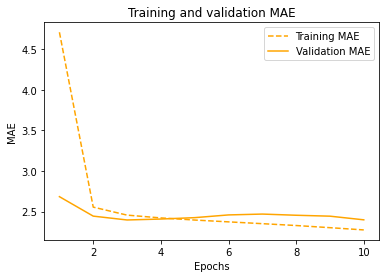

In [20]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="orange", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="orange", linestyle="-", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


**Let's use LSTM dropout Regularization**

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 74s 89ms/step - loss: 46.9604 - mae: 5.0927 - val_loss: 12.9144 - val_mae: 2.7276
Epoch 2/10
819/819 [==============================] - 71s 87ms/step - loss: 19.8445 - mae: 3.4198 - val_loss: 9.7871 - val_mae: 2.4324
Epoch 3/10
819/819 [==============================] - 72s 88ms/step - loss: 18.1491 - mae: 3.2725 - val_loss: 9.3304 - val_mae: 2.3782
Epoch 4/10
819/819 [==============================] - 72s 87ms/step - loss: 17.3964 - mae: 3.2050 - val_loss: 9.2973 - val_mae: 2.3714
Epoch 5/10
819/819 [==============================] - 72s 88ms/step - loss: 16.8105 - mae: 3.1523 - val_loss: 9.5777 - val_mae: 2.4031
Epoch 6/10
819/819 [==============================] - 72s 88ms/step - loss: 16.1479 - mae: 3.0907 - val_loss: 9.0657 - val_mae: 2.3383
Epoch 7/10
819/819 [==============================] - 72s 88ms/step - loss: 15.6895 - mae: 3.0484 - val_loss: 9.1058 - val_mae: 2.3453
Epoch 8/10
819/819 [==============================] - 

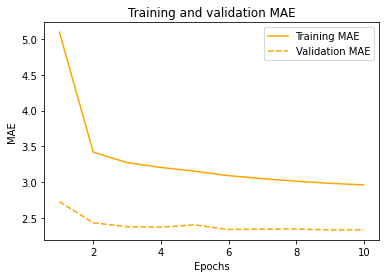

In [22]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="orange", linestyle="-", label="Training MAE")
plt.plot(epochs, val_loss, color="orange", linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


**LSTM Stacked setup with 8 units**

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 76s 90ms/step - loss: 64.3068 - mae: 6.0818 - val_loss: 30.4837 - val_mae: 4.0722
Epoch 2/10
819/819 [==============================] - 68s 83ms/step - loss: 19.0686 - mae: 3.2455 - val_loss: 11.9338 - val_mae: 2.6128
Epoch 3/10
819/819 [==============================] - 62s 76ms/step - loss: 11.0381 - mae: 2.5794 - val_loss: 9.4015 - val_mae: 2.3701
Epoch 4/10
819/819 [==============================] - 65s 80ms/step - loss: 10.0552 - mae: 2.4728 - val_loss: 9.4232 - val_mae: 2.3837
Epoch 5/10
819/819 [==============================] - 66s 81ms/step - loss: 9.8059 - mae: 2.4387 - val_loss: 9.0442 - val_mae: 2.3344
Epoch 6/10
819/819 [==============================] - 57s 70ms/step - loss: 9.6532 - mae: 2.4179 - val_loss: 9.1547 - val_mae: 2.3483
Epoch 7/10
819/819 [==============================] - 66s 80ms/step - loss: 9.5309 - mae: 2.4017 - val_loss: 9.1283 - val_mae: 2.3448
Epoch 8/10
819/819 [==============================] - 66

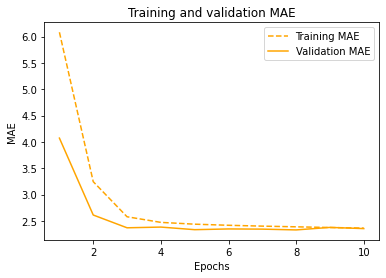

In [24]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="orange", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="orange", linestyle="-", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**LSTM Stacked setup with 16 units**

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 86s 102ms/step - loss: 35.7025 - mae: 4.3388 - val_loss: 11.6038 - val_mae: 2.6040
Epoch 2/10
819/819 [==============================] - 81s 99ms/step - loss: 9.8957 - mae: 2.4415 - val_loss: 9.5061 - val_mae: 2.3956
Epoch 3/10
819/819 [==============================] - 83s 102ms/step - loss: 8.6076 - mae: 2.2911 - val_loss: 9.4525 - val_mae: 2.3893
Epoch 4/10
819/819 [==============================] - 83s 101ms/step - loss: 7.9444 - mae: 2.2037 - val_loss: 9.5036 - val_mae: 2.4057
Epoch 5/10
819/819 [==============================] - 80s 97ms/step - loss: 7.4614 - mae: 2.1344 - val_loss: 9.8851 - val_mae: 2.4432
Epoch 6/10
819/819 [==============================] - 83s 101ms/step - loss: 7.0402 - mae: 2.0721 - val_loss: 10.4737 - val_mae: 2.5173
Epoch 7/10
819/819 [==============================] - 83s 102ms/step - loss: 6.7081 - mae: 2.0184 - val_loss: 11.2972 - val_mae: 2.6166
Epoch 8/10
819/819 [==============================] -

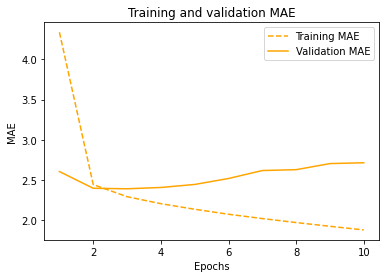

In [26]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="orange", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="orange",linestyle="-", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**LSTM Stacked setup with 32 units**

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 113s 136ms/step - loss: 19.5369 - mae: 3.1811 - val_loss: 10.2896 - val_mae: 2.4968
Epoch 2/10
819/819 [==============================] - 108s 132ms/step - loss: 7.9783 - mae: 2.1977 - val_loss: 11.0268 - val_mae: 2.5885
Epoch 3/10
819/819 [==============================] - 107s 131ms/step - loss: 6.4504 - mae: 1.9663 - val_loss: 11.8193 - val_mae: 2.7058
Epoch 4/10
819/819 [==============================] - 110s 135ms/step - loss: 5.4990 - mae: 1.8073 - val_loss: 12.2003 - val_mae: 2.7490
Epoch 5/10
819/819 [==============================] - 104s 127ms/step - loss: 4.7514 - mae: 1.6717 - val_loss: 12.7997 - val_mae: 2.8006
Epoch 6/10
819/819 [==============================] - 113s 137ms/step - loss: 4.2067 - mae: 1.5664 - val_loss: 12.6910 - val_mae: 2.8015
Epoch 7/10
819/819 [==============================] - 113s 139ms/step - loss: 3.7772 - mae: 1.4819 - val_loss: 13.3130 - val_mae: 2.8580
Epoch 8/10
819/819 [====================

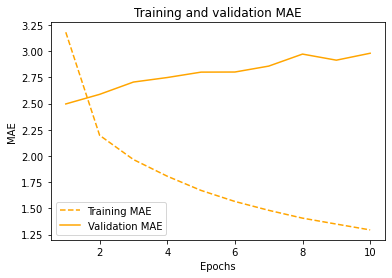

In [28]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="orange", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="orange",linestyle="-", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**LSTM dropout-regularized, stacked model**

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 132s 157ms/step - loss: 89.3452 - mae: 7.3862 - val_loss: 45.7609 - val_mae: 5.0819
Epoch 2/10
819/819 [==============================] - 128s 156ms/step - loss: 35.7254 - mae: 4.4437 - val_loss: 16.0582 - val_mae: 2.9654
Epoch 3/10
819/819 [==============================] - 127s 156ms/step - loss: 24.9929 - mae: 3.7745 - val_loss: 12.1151 - val_mae: 2.6627
Epoch 4/10
819/819 [==============================] - 129s 157ms/step - loss: 22.6769 - mae: 3.6071 - val_loss: 10.3911 - val_mae: 2.4783
Epoch 5/10
819/819 [==============================] - 128s 156ms/step - loss: 21.3873 - mae: 3.5135 - val_loss: 10.3998 - val_mae: 2.4873
Epoch 6/10
819/819 [==============================] - 127s 155ms/step - loss: 20.1899 - mae: 3.4150 - val_loss: 9.8535 - val_mae: 2.4189
Epoch 7/10
819/819 [==============================] - 126s 154ms/step - loss: 19.3608 - mae: 3.3454 - val_loss: 9.5452 - val_mae: 2.3803
Epoch 8/10
819/819 [================

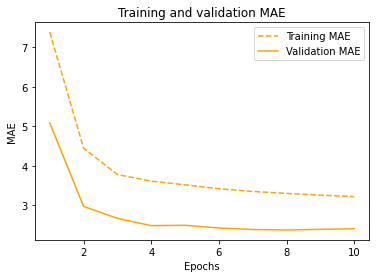

In [30]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="orange", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="orange",linestyle="-", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Bidirectional LSTM**

In [31]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 49s 57ms/step - loss: 27.6768 - mae: 3.7543 - val_loss: 10.3608 - val_mae: 2.4981
Epoch 2/10
819/819 [==============================] - 47s 57ms/step - loss: 9.4728 - mae: 2.4002 - val_loss: 9.6989 - val_mae: 2.4150
Epoch 3/10
819/819 [==============================] - 46s 56ms/step - loss: 8.6695 - mae: 2.2945 - val_loss: 9.6104 - val_mae: 2.4101
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 8.0732 - mae: 2.2186 - val_loss: 9.7916 - val_mae: 2.4383
Epoch 5/10
819/819 [==============================] - 46s 56ms/step - loss: 7.6048 - mae: 2.1555 - val_loss: 10.1787 - val_mae: 2.4914
Epoch 6/10
819/819 [==============================] - 42s 52ms/step - loss: 7.2735 - mae: 2.1084 - val_loss: 10.4308 - val_mae: 2.5225
Epoch 7/10
819/819 [==============================] - 46s 56ms/step - loss: 6.9898 - mae: 2.0676 - val_loss: 10.5188 - val_mae: 2.5227
Epoch 8/10
819/819 [==============================] - 46s

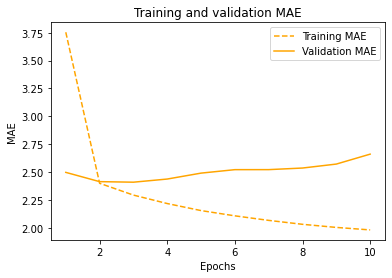

In [32]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="orange", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="orange",linestyle="-", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**1D Convnets and LSTM togther**

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 41s 48ms/step - loss: 46.2417 - mae: 5.0672 - val_loss: 26.0619 - val_mae: 3.9422
Epoch 2/10
819/819 [==============================] - 38s 47ms/step - loss: 17.3458 - mae: 3.2110 - val_loss: 23.7973 - val_mae: 3.8131
Epoch 3/10
819/819 [==============================] - 38s 47ms/step - loss: 14.3656 - mae: 2.9303 - val_loss: 21.8004 - val_mae: 3.7597
Epoch 4/10
819/819 [==============================] - 38s 47ms/step - loss: 12.7814 - mae: 2.7611 - val_loss: 24.6805 - val_mae: 3.8933
Epoch 5/10
819/819 [==============================] - 39s 47ms/step - loss: 11.6744 - mae: 2.6332 - val_loss: 23.7198 - val_mae: 3.9332
Epoch 6/10
819/819 [==============================] - 38s 47ms/step - loss: 10.8600 - mae: 2.5344 - val_loss: 23.4733 - val_mae: 3.8737
Epoch 7/10
819/819 [==============================] - 39s 47ms/step - loss: 10.1899 - mae: 2.4463 - val_loss: 22.9026 - val_mae: 3.8106
Epoch 8/10
819/819 [============================

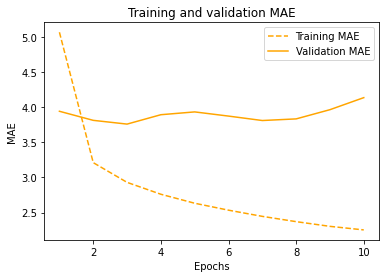

In [38]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="orange", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="orange",linestyle="-", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

As above seen we made a total of 14 models. 

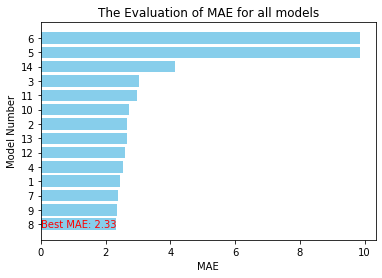

In [39]:
import matplotlib.pyplot as plt

Models = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14"]
Mae = [2.44, 2.67, 3.04, 2.54, 9.85, 9.85, 2.39, 2.33, 2.35, 2.71, 2.98, 2.61, 2.66, 4.13]

# Sorting models by their MAE values
sorted_indices = sorted(range(len(Mae)), key=lambda k: Mae[k])
sorted_models = [Models[i] for i in sorted_indices]
sorted_mae = [Mae[i] for i in sorted_indices]

plt.barh(sorted_models, sorted_mae, color="skyblue")
plt.title("The Evaluation of MAE for all models")
plt.xlabel("MAE")
plt.ylabel("Model Number")

# Adding annotation for the lowest MAE value
lowest_mae_index = sorted_mae.index(min(sorted_mae))
lowest_mae_value = min(sorted_mae)
plt.text(lowest_mae_value, lowest_mae_index, f"Best MAE: {lowest_mae_value}", va='center', ha='right', color='red')

plt.show()


END